<a href="https://colab.research.google.com/github/Otavio8888/macroeconometric/blob/ipca_inflation_decomposition/20260109_previsao_ipca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Atualização de resultados dos modelos de inflação da AM
---

O IPCA fechou 2025 em 4.26%, ficando acima da meta de 3% ao ano, mas dentro do intevalo de tolerância de ±1,5 ponto percentual. O valor veio abaixo da previsão da Análise Macro, de 4.66%, e abaixo do previsto pelo Boletim Focus, de 4.30%.


Analisando os itens que compõem o índice, cinco dos nove grupos ficaram acima da meta de inflação, com destaques para Despesas pessoais, Educação e Habitação. O único grupo que apresentou deflação moderada foi Artigos de residência.



# Bibliotecas

In [ ]:
# Bibliotecas
import pandas as pd
import plotnine as p9

# Coleta e tratamento de dados

In [ ]:
# IPCA cheio
ipca_cheio = (
    pd.read_json(
    "https://apisidra.ibge.gov.br/values/t/1737/n1/all/v/63,2265/p/all/d/v63%202,v2265%202?formato=json"
    )
    .rename(
        columns = {
            "V": "valor",
            "D2N": "variavel",
            "D3C": "data"
        }
    )
    .iloc[1:]
    .query("valor not in ['...']")
    .assign(
        data = lambda x: pd.to_datetime(x.data, format = "%Y%m"),
        valor = lambda x: x.valor.astype(float)
    )
    .filter(["data", "variavel", "valor"])
    .set_index("data")
)

In [ ]:
# Previsões AM
previsao_am = (
    pd.read_csv("tracking.csv")
    .query("`Variável` == 'IPCA' and Modelo == 'Ridge' and `Data da Previsão` in ['2026-01-08 17:24:37.500550']")
    .assign(**{
        "Data de Referência": lambda x: pd.to_datetime(x["Data de Referência"])
    })
    .set_index("Data de Referência")
    .filter(["Previsão"])
    .rename(columns = {"Previsão": "valor"})
    .assign(variavel = "Previsão Otávio")
)

In [ ]:
# Previsões Focus
previsao_focus = (
    pd.read_csv(
        "https://olinda.bcb.gov.br/olinda/servico/Expectativas/versao/v1/odata/ExpectativaMercadoMensais?$filter=Indicador%20eq%20'IPCA'%20and%20Data%20ge%20'2026-01-01'%20and%20baseCalculo%20eq%200&$format=text/csv",
        decimal = ","
        )
    .assign(
        Data = lambda x: pd.to_datetime(x.Data, format = "%Y-%m-%d"),
        DataReferencia = lambda x: pd.to_datetime(x.DataReferencia, format = "%m/%Y"),
    )
    .query("Data == Data.max() and DataReferencia in @previsao_am.index")
    .set_index("DataReferencia")
    .filter(["Mediana"])
    .rename(columns = {"Mediana": "valor"})
    .assign(variavel = "Previsão Focus")
)

In [ ]:
# Previsões Focus Top5
previsao_focus_top5 = (
    pd.read_csv(
        "https://olinda.bcb.gov.br/olinda/servico/Expectativas/versao/v1/odata/ExpectativasMercadoTop5Mensais?$filter=Indicador%20eq%20'IPCA'%20and%20Data%20ge%20'2026-01-01'%20and%20tipoCalculo%20eq%20'C'&$format=text/csv",
        decimal = ","
        )
    .assign(
        Data = lambda x: pd.to_datetime(x.Data, format = "%Y-%m-%d"),
        DataReferencia = lambda x: pd.to_datetime(x.DataReferencia, format = "%m/%Y"),
    )
    .query("Data == Data.max() and DataReferencia in @previsao_am.index")
    .set_index("DataReferencia")
    .filter(["Mediana"])
    .rename(columns = {"Mediana": "valor"})
    .assign(variavel = "Previsão Focus Top5")
)


In [ ]:
# Grupos do IPCA
ipca_grupos = (
    pd.read_json(
        "https://apisidra.ibge.gov.br/values/t/7060/n1/all/v/2265/p/last%201/c315/7170,7445,7486,7558,7625,7660,7712,7766,7786/d/v2265%202?formato=json"
    )
    .rename(
        columns = {
            "V": "valor",
            "D4N": "grupo",
            "D3C": "data"
        }
    )
    .iloc[1:]
    .assign(
        data = lambda x: pd.to_datetime(x.data, format = "%Y%m"),
        valor = lambda x: x.valor.astype(float),
        grupo = lambda x: x.grupo.str.replace(r"\d\.", "", regex=True)
    )
    .filter(["data", "grupo", "valor"])
    .sort_values("valor")
    .assign(grupo = lambda x: pd.Categorical(x.grupo, categories = x.grupo))
)

# Visualização de dados

/usr/local/lib/python3.12/dist-packages/mizani/breaks.py:448: FutureWarning: Passing the width as the parameter has been deprecated and will not work in a future version. Use breaks_date(width="4 years")


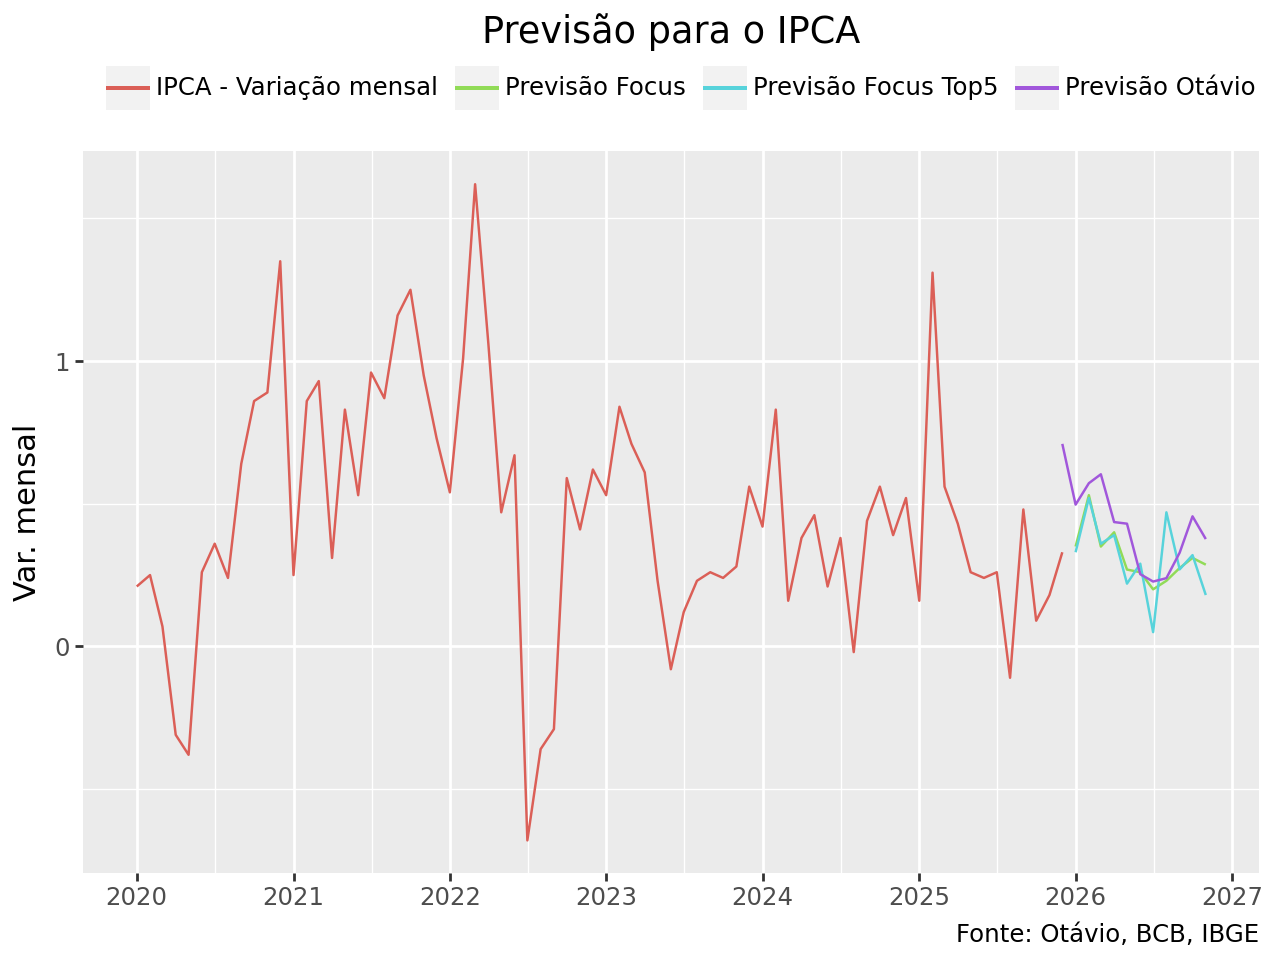

In [ ]:
# Gráfico de previsão
df_plot = (
    pd.concat([ipca_cheio.query("variavel == 'IPCA - Variação mensal'"), previsao_am, previsao_focus, previsao_focus_top5])
    .query("index >= '2020-01-01'")
    .reset_index()
)
(
    p9.ggplot(df_plot) +
    p9.aes(x = "index", y = "valor", color = "variavel") +
    p9.geom_line() +
    p9.scale_x_date(date_labels = "%Y", date_breaks = "1 year") +
    p9.labs(
        title = "Previsão para o IPCA",
        x = "",
        y = "Var. mensal",
        color = "",
        caption = "Fonte: Otávio, BCB, IBGE"
        ) +
    p9.theme(legend_position = "top")
)

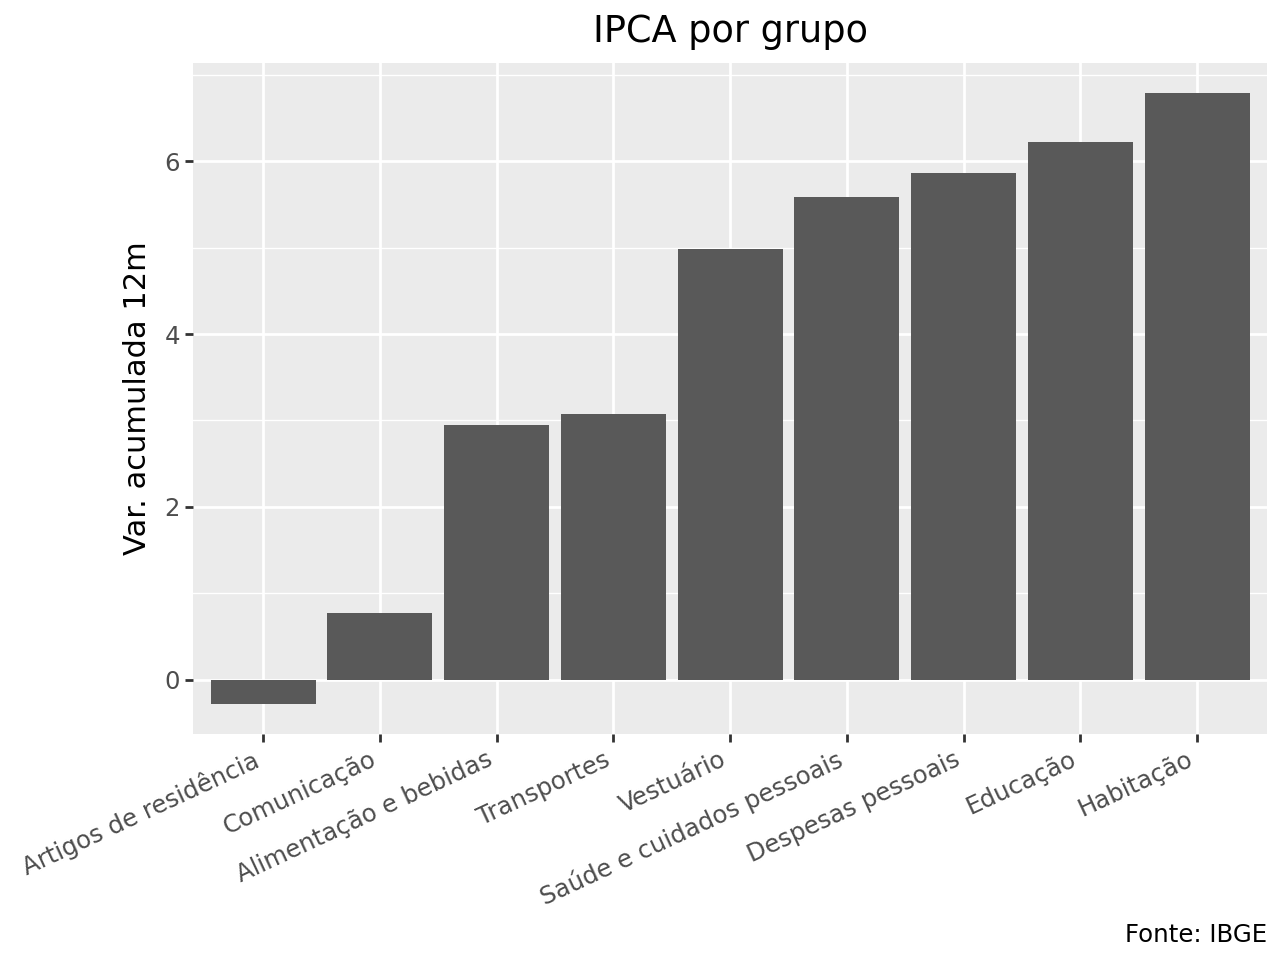

In [ ]:
# Gráfico dos grupos
(
    p9.ggplot(ipca_grupos) +
    p9.aes(x = "grupo", y = "valor") +
    p9.geom_col() +
    p9.labs(
        title = "IPCA por grupo",
        x = "",
        y = "Var. acumulada 12m",
        caption = "Fonte: IBGE"
    ) +
    p9.theme(axis_text_x = p9.element_text(rotation = 25, hjust = 1))
)